# **Mount Drive**

In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Import Python Packages**


In [2]:

#Import Python Packages
import logging
import os
from os.path import splitext
from os import listdir
from glob import glob
import sys
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from random import randint
import random;
from PIL import Image
from skimage import transform as tf
import math
from skimage import exposure
from skimage import feature
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
import pandas as pd;
from typing import Any
import matplotlib.pyplot as plt

# **Neural Network Classes**

In [3]:

#Batch Norm --> Turn up learning rate; add after

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 128),
            #nn.Linear(256 * 6 * 6, 16),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 128),
            #nn.Linear(16, 16),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            #nn.Linear(16, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:

    model = AlexNet(**kwargs)
    return model




# **Function: Dataset**

In [4]:
class BasicDataset(Dataset):
    
    
###############################################################################
# Class: Initialization
###############################################################################   
    
    def __init__(self, img_patches, groups, indices):
        


        #Image Attributes
        self.img_patches = img_patches;
        self.groups = groups;
        self.ids = indices.tolist();


###############################################################################
# Method: Length
###############################################################################  

    def __len__(self):
        return len(self.ids)



###############################################################################
# Method: Get Item
###############################################################################  

    def __getitem__(self, i):
        
        #Obtain Image File 
        idx = int(self.ids[i]);
        img = self.img_patches[idx,:,:,:]
        img = img.squeeze();
        group = np.array(self.groups[idx]);

        
        #Flip the Image (Horizontal)
        Flip_Random = randint(0,1);
        if(Flip_Random ==1):
            img = np.fliplr(img);
            img = img.copy();
    
    
        #Flip the Image (Vertical)
        Flip_Random = randint(0,1);
        if(Flip_Random ==1):
            img = np.flipud(img);
            img = img.copy();


        #Preprocess Image
        img = img.reshape(1, 64, 64);
        
      
        return {'image': torch.from_numpy(img), 'class': torch.from_numpy(group)}


# **Function: Evaluate Neural Network**

In [5]:
def eval_net(net, loader, device, n_val):
    """Evaluation without the densecrf with the dice coefficient"""
    
    #Set the Network to Eval Mode for the Dropout Layer
    net.eval();
    

    #Initialize Validation Accuracy
    val_count_0 = 0;
    val_count_1 = 0;
    val_count_2 = 0;
    val_count_3 = 0;
    #val_count_4 = 0;
    val_accuracy_0 = 0;
    val_accuracy_1 = 0;
    val_accuracy_2 = 0;
    val_accuracy_3 = 0;
    #val_accuracy_4 = 0;

    #Display Progress Bar
    with tqdm(total=n_val, desc='Validation round', unit='img', leave=False) as pbar:
        
        #Iterate through the Batches
        for batch in loader:
          

            #Extract from Data Loader
            imgs = batch['image'];
            imgs = imgs.to(device=device, dtype=torch.float32);
            true_class = batch['class'];         
            if(true_class.cpu().numpy().size>1):   
                true_class = true_class.to(device=device, dtype=torch.long).squeeze();   
            else:
                true_class = true_class.to(device=device, dtype=torch.long)
            true_class = true_class.cpu().numpy();
                
            #Predict the Class
            pred = net(imgs);
  

            #Calculate Accuracy
            pred = pred.cpu().detach().numpy()
            pred = np.argmax(pred, axis =1);      
            class_0 = np.array(np.where(true_class==0)).squeeze();
            class_1 = np.array(np.where(true_class==1)).squeeze();
            class_2 = np.array(np.where(true_class==2)).squeeze();
            class_3 = np.array(np.where(true_class==3)).squeeze();
            #class_4 = np.array(np.where(true_class==4)).squeeze();
            if(class_0.size >0):
                val_accuracy_0 += np.sum(pred[class_0]==true_class[class_0])/class_0.size;
                val_count_0 +=1.0;
            if(class_1.size >0):
                val_accuracy_1 += np.sum(pred[class_1]==true_class[class_1])/class_1.size;
                val_count_1 +=1.0;
            if(class_2.size >0):
                val_accuracy_2 += np.sum(pred[class_2]==true_class[class_2])/class_2.size;
                val_count_2 +=1.0;
            if(class_3.size >0):
                val_accuracy_3 += np.sum(pred[class_3]==true_class[class_3])/class_3.size;
                val_count_3 +=1.0;       
            #if(class_4.size >0):
            #    val_accuracy_4 += np.sum(pred[class_4]==true_class[class_4])/class_4.size;
            #    val_count_4 +=1.0;   

         
            
            
            #Update Progress Bar
            pbar.update(imgs.shape[0]);

    #Calculate Average Validation Accuracy
    avg_val_accuracy_0 = val_accuracy_0/val_count_0;
    avg_val_accuracy_1 = val_accuracy_1/val_count_1;
    avg_val_accuracy_2 = val_accuracy_2/val_count_2;
    avg_val_accuracy_3 = val_accuracy_3/val_count_3;
    #avg_val_accuracy_4 = val_accuracy_4/val_count_4;
    avg_val_accuracy = np.mean([avg_val_accuracy_0, avg_val_accuracy_1, avg_val_accuracy_2, avg_val_accuracy_3]);
    #avg_val_accuracy = np.mean([avg_val_accuracy_0, avg_val_accuracy_1, avg_val_accuracy_2, avg_val_accuracy_3, avg_val_accuracy_4]);
  
    return avg_val_accuracy, avg_val_accuracy_0, avg_val_accuracy_1, avg_val_accuracy_2, avg_val_accuracy_3;
    #return avg_val_accuracy, avg_val_accuracy_0, avg_val_accuracy_1, avg_val_accuracy_2, avg_val_accuracy_3, avg_val_accuracy_4;


# **Function: Train Neural Network**

In [6]:

def train_net(net, img_patches, groups, cp_dir, epochs, lr, batch_size, save_cp):

    
    #Accuracy Arrays
    #training = np.zeros((6,epochs));
    #validation = np.zeros((6,epochs));
    #training_loss = np.zeros((6,epochs));

    training = np.zeros((5,epochs));
    validation = np.zeros((5,epochs));
    training_loss = np.zeros((5,epochs));


    #Inverse Class Weights
    ratio_0 = len(groups)/float(np.array(np.where(groups==0)).size);
    ratio_1 = len(groups)/float(np.array(np.where(groups==1)).size);
    ratio_2 = len(groups)/float(np.array(np.where(groups==2)).size);
    ratio_3 = len(groups)/float(np.array(np.where(groups==3)).size);
    #ratio_4 = len(groups)/float(np.array(np.where(groups==4)).size);
    #ratio_sum = ratio_0 + ratio_1 + ratio_2 + ratio_3 + ratio_4;
    ratio_sum = ratio_0 + ratio_1 + ratio_2 + ratio_3;
    ratio_0 /= ratio_sum;
    ratio_1 /= ratio_sum;
    ratio_2 /= ratio_sum;
    ratio_3 /= ratio_sum;
    #ratio_4 /= ratio_sum;
    #weights = [ratio_0, ratio_1, ratio_2, ratio_3, ratio_4];
    weights = [ratio_0, ratio_1, ratio_2, ratio_3];
    class_weights = torch.FloatTensor(weights).cuda();


    #Split into Training & Validation Set
    val_indices = np.zeros((0,0));
    train_indices = np.zeros((0,0));
    #for k in range(0,5):
    for k in range(0,4):

        indices = np.array(np.where(groups==k)).astype(np.int32).squeeze();
        val_idx = indices[0:int(0.1*len(indices))];
        val_indices = np.concatenate((val_indices, val_idx), axis=None)
        train_idx = indices[int(0.1*len(indices)):];
        train_indices = np.concatenate((train_indices, train_idx), axis=None)

    np.random.shuffle(val_indices)  
    np.random.shuffle(train_indices)




    #Construct a Dataset Object
    train_dataset = BasicDataset(img_patches, groups, train_indices);
    val_dataset = BasicDataset(img_patches, groups, val_indices);


    

    #Collate Individual Fetched Data Samples into Batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True);
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True);

    #Summary Writer will Write out Events and Summaries to the Event File
    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}');
    
    #Initialize Overall (Global) Step
    global_step = 0;

    #Write the Training Parameters to the Log File
    logging.info(f'''Started training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {len(train_dataset)}
        Validation size: {len(val_dataset)}
        Checkpoints:     {save_cp}
        Device:          {device.type}
    ''');


    #The Optimizer Object will Hold the Current State and will Update the 
    #Parameters based on the Computed Gradients
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8);
    scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)
  
    


    #Iterate through Epochs
    for epoch in range(epochs):
        
        #Begin Training
        net.train();


        #Initialize Epoch Loss
        loss_0 = 0;
        loss_1 = 0;
        loss_2 = 0;
        loss_3 = 0;
        #loss_4 = 0;
        loss_count_0 = 0;
        loss_count_1 = 0;
        loss_count_2 = 0;
        loss_count_3 = 0;
        #loss_count_4 = 0;


        #Initialize Training Accuracy
        train_count_0 = 0;
        train_count_1 = 0;
        train_count_2 = 0;
        train_count_3 = 0;
        #train_count_4 = 0;
        train_accuracy_0 = 0;
        train_accuracy_1 = 0;
        train_accuracy_2 = 0;
        train_accuracy_3 = 0;
        #train_accuracy_4 = 0;
        
        #Display Progress Bar
        with tqdm(total=len(train_dataset), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            
            
            #Iterate through the Batches in the Training Set
            for batch in train_loader:
                


                #Extract from Data Loader
                imgs = batch['image'];
                imgs = imgs.to(device=device, dtype=torch.float32);
                true_class = batch['class'];         
                if(true_class.cpu().numpy().size>1):   
                    true_class = true_class.to(device=device, dtype=torch.long).squeeze();   
                else:
                    true_class = true_class.to(device=device, dtype=torch.long)

                #Predict the Class
                pred = net(imgs);
      



                #Calculate Loss
                criterion = nn.CrossEntropyLoss(weight = class_weights, reduction = 'none');
                loss_matrix = criterion(pred, true_class); 
                loss = torch.mean(loss_matrix);

  

                #Calculate Accuracy
                pred = pred.cpu().detach().numpy()
                pred = np.argmax(pred, axis =1);
                true_class = true_class.cpu().numpy();
                class_0 = np.array(np.where(true_class==0)).squeeze();
                class_1 = np.array(np.where(true_class==1)).squeeze();
                class_2 = np.array(np.where(true_class==2)).squeeze();
                class_3 = np.array(np.where(true_class==3)).squeeze();
                #class_4 = np.array(np.where(true_class==4)).squeeze();
                if(class_0.size >0):
                    train_accuracy_0 += np.sum(pred[class_0]==true_class[class_0])/class_0.size;
                    train_count_0 +=1.0;
                if(class_1.size >0):
                    train_accuracy_1 += np.sum(pred[class_1]==true_class[class_1])/class_1.size;
                    train_count_1 +=1.0;
                if(class_2.size >0):
                    train_accuracy_2 += np.sum(pred[class_2]==true_class[class_2])/class_2.size;
                    train_count_2 +=1.0;
                if(class_3.size >0):
                    train_accuracy_3 += np.sum(pred[class_3]==true_class[class_3])/class_3.size;
                    train_count_3 +=1.0;       
                #if(class_4.size >0):
                #    train_accuracy_4 += np.sum(pred[class_4]==true_class[class_4])/class_4.size;
                #    train_count_4 +=1.0;   



                #Calculate Loss
                loss_size = loss_matrix.cpu().detach().numpy().shape[0]
                loss_list = np.zeros((1,loss_size));
                for i in range(0,loss_size):
                    loss_list[0,i] = loss_matrix[i].item();
                if(class_0.size >0):
                    loss_0 += np.sum(loss_list[0,class_0])/class_0.size;
                    loss_count_0 +=1.0;
                if(class_1.size >0):
                    loss_1 += np.sum(loss_list[0,class_1])/class_1.size;
                    loss_count_1 +=1.0;
                if(class_2.size >0):
                    loss_2 += np.sum(loss_list[0,class_2])/class_2.size;
                    loss_count_2 +=1.0;
                if(class_3.size >0):
                    loss_3 += np.sum(loss_list[0,class_3])/class_3.size;
                    loss_count_3 +=1.0;
                #if(class_4.size >0):
                #    loss_4 += np.sum(loss_list[0,class_4])/class_4.size;
                #    loss_count_4 +=1.0;

                #Update 
                writer.add_scalar('Loss/train', loss.item(), global_step)
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                global_step += 1

                #Clear Old Gradients from the Last Step
                optimizer.zero_grad();
                loss.backward();
                optimizer.step();


                pbar.update(imgs.shape[0])

        #Evaluate the Network on the Validation Set
        #avg_val_accuracy, avg_val_accuracy_0, avg_val_accuracy_1, avg_val_accuracy_2, avg_val_accuracy_3, avg_val_accuracy_4  = eval_net(net, val_loader, device, len(train_dataset));
        avg_val_accuracy, avg_val_accuracy_0, avg_val_accuracy_1, avg_val_accuracy_2, avg_val_accuracy_3 = eval_net(net, val_loader, device, len(train_dataset));


        #Training Accuracy
        avg_train_accuracy_0 = train_accuracy_0/train_count_0;
        avg_train_accuracy_1 = train_accuracy_1/train_count_1;
        avg_train_accuracy_2 = train_accuracy_2/train_count_2;
        avg_train_accuracy_3 = train_accuracy_3/train_count_3;
        #avg_train_accuracy_4 = train_accuracy_4/train_count_4;
        #avg_train_accuracy = np.mean([avg_train_accuracy_0, avg_train_accuracy_1, avg_train_accuracy_2, avg_train_accuracy_3, avg_train_accuracy_4]);
        avg_train_accuracy = np.mean([avg_train_accuracy_0, avg_train_accuracy_1, avg_train_accuracy_2, avg_train_accuracy_3]);


        #Epoch Loss
        avg_loss_0 = loss_0/loss_count_0;
        avg_loss_1 = loss_1/loss_count_1;
        avg_loss_2 = loss_2/loss_count_2;
        avg_loss_3 = loss_3/loss_count_3;
        #avg_loss_4 = loss_4/loss_count_4;
        #avg_loss = np.mean([avg_loss_0, avg_loss_1, avg_loss_2, avg_loss_3, avg_loss_4]);
        avg_loss = np.mean([avg_loss_0, avg_loss_1, avg_loss_2, avg_loss_3]);

        #Print Results
        logging.info('Average Train Accuracy: ' + str(avg_train_accuracy))
        logging.info('Average Train Accuracy 0: ' + str(avg_train_accuracy_0))  
        logging.info('Average Train Accuracy 1: ' + str(avg_train_accuracy_1))  
        logging.info('Average Train Accuracy 2: ' + str(avg_train_accuracy_2))  
        logging.info('Average Train Accuracy 3: ' + str(avg_train_accuracy_3))  
        #logging.info('Average Train Accuracy 4: ' + str(avg_train_accuracy_4))  
        logging.info('Average Val Accuracy: ' + str(avg_val_accuracy))   
        logging.info('Average Val Accuracy 0: ' + str(avg_val_accuracy_0))  
        logging.info('Average Val Accuracy 1: ' + str(avg_val_accuracy_1))  
        logging.info('Average Val Accuracy 2: ' + str(avg_val_accuracy_2))  
        logging.info('Average Val Accuracy 3: ' + str(avg_val_accuracy_3))  
        #logging.info('Average Val Accuracy 4: ' + str(avg_val_accuracy_4)) 
        logging.info('Average Loss: ' + str(avg_loss))  
        logging.info('Average Loss 0: ' + str(avg_loss_0))  
        logging.info('Average Loss 1: ' + str(avg_loss_1))  
        logging.info('Average Loss 2: ' + str(avg_loss_2))  
        logging.info('Average Loss 3: ' + str(avg_loss_3))  
        #logging.info('Average Loss 4: ' + str(avg_loss_4))  

        #Fill Arrays
        training[0,epoch] = avg_train_accuracy;
        training[1,epoch] = avg_train_accuracy_0;
        training[2,epoch] = avg_train_accuracy_1;
        training[3,epoch] = avg_train_accuracy_2;
        training[4,epoch] = avg_train_accuracy_3;
        #training[5,epoch] = avg_train_accuracy_4;
        validation[0,epoch] = avg_val_accuracy;
        validation[1,epoch] = avg_val_accuracy_0;
        validation[2,epoch] = avg_val_accuracy_1;
        validation[3,epoch] = avg_val_accuracy_2;
        validation[4,epoch] = avg_val_accuracy_3;
        #validation[5,epoch] = avg_val_accuracy_4;
        training_loss[0,epoch] = avg_loss;
        training_loss[1,epoch] = avg_loss_0;
        training_loss[2,epoch] = avg_loss_1;
        training_loss[3,epoch] = avg_loss_2;
        training_loss[4,epoch] = avg_loss_3;
        #training_loss[5,epoch] = avg_loss_4;

        #Learning Rate Scheduler
        scheduler.step()            
            
        #Save the Model
        if save_cp:
            try:
                os.mkdir(cp_dir)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       cp_dir +  f'AlexNet_LR_{lr}_BS_{batch_size}_CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()


    return training, validation, training_loss;


# **Load Data** 

In [21]:
vortex =0;
num = 5;
if(vortex==1):

    string = 'Vortex';
else:
    string = 'Expanded';


#Load Files
img_patches = np.load(r'/content/drive/My Drive/project/X_Data_'+ string + '_' + str(num) + '.npy');
groups = np.load(r'/content/drive/My Drive/project/Group_Labels_'+ string + '_' + str(num) + '.npy').squeeze();
dx = np.load(r'/content/drive/My Drive/project/Dx_Labels_'+ string + '_' + str(num) + '.npy');
pid = np.load(r'/content/drive/My Drive/project/PID_Labels_'+ string + '_' + str(num) + '.npy');

print(img_patches.shape)

for k in range(0,4):
#for k in range(0,5):

    indices = np.array(np.where(groups==k)).astype(np.int32).squeeze();

    print('Group ' + str(k) + ': ' + str(len(indices)))


(131625, 64, 64, 1)
Group 0: 16710
Group 1: 17763
Group 2: 17607
Group 3: 79545


# **Main Method**

In [8]:

#Parameters
epochs = 3;
lr = 1e-5; 
batch_size = 5;

load_model = False;
save_cp = True;


#Directory Locations
cp_dir = r'/content/drive/My Drive/checkpoints/';

#Attempt to use GPU instead of CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');

#Set up Basic Configuration of the Log File
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s');
logging.info(f'Using device {device}');

#Initialize Model
net = AlexNet(num_classes=4);
if(load_model):
  Model_File = r'/content/drive/My Drive/checkpoints/MODEL_INTERRUPTED.pth'
  logging.info(f'Model loaded from {Model_File}')
net.to(device=device)


try:


    #Train the Network    
    net.to(device=device)
    training, validation, training_loss = train_net(net, img_patches, groups, cp_dir, epochs, lr, batch_size, save_cp);

        

except KeyboardInterrupt:
    
    try:
        os.mkdir(cp_dir)
        logging.info('Created checkpoint directory')
    except OSError:
        pass  

    #Save the Model File to the INTERRUPTED.pth
    Interrupted_File = r'/content/drive/My Drive/checkpoints/MODEL_INTERRUPTED.pth'
    torch.save(net.state_dict(), Interrupted_File)
        
        
    #Log the Interruption
    logging.info('Saved interrupt')





INFO: Using device cuda


KeyboardInterrupt: ignored

# **Plot Training**

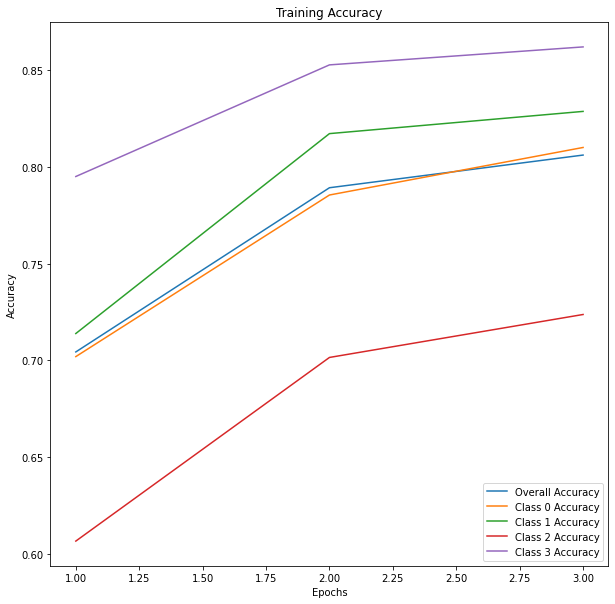

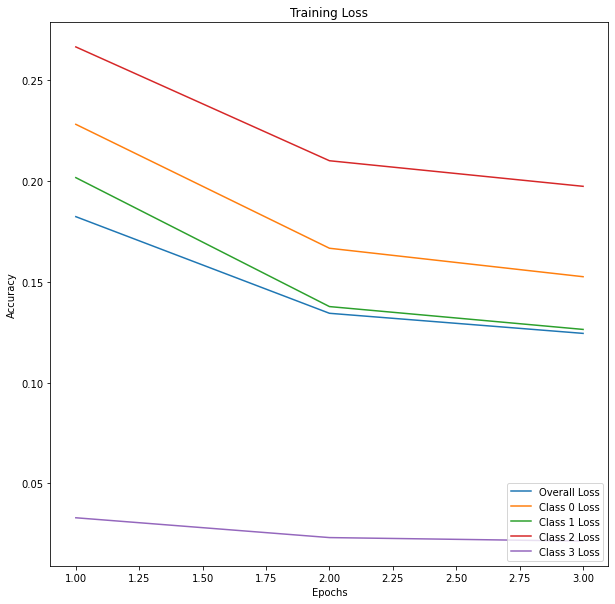

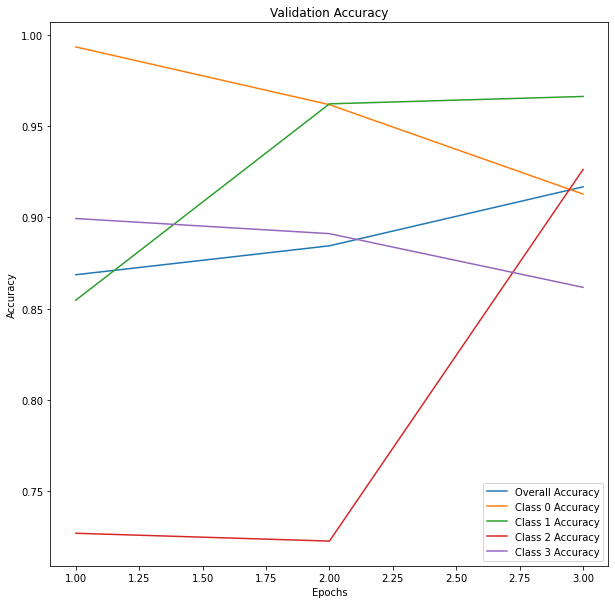

In [22]:


#Save Data
np.save(r'/content/drive/My Drive/project/Training_'+ string + '_' + str(num) + '.npy', training);
np.save(r'/content/drive/My Drive/project/Training_Loss_'+ string + '_' + str(num) + '.npy', training_loss);
np.save(r'/content/drive/My Drive/project/Validation_'+ string + '_' + str(num) + '.npy', validation);
torch.save(net.state_dict(), r'/content/drive/My Drive/project/AlexNet_'+ string + '_' + str(num) + '.pth')



#Plot Training
epoch_list = np.array(range(1,epochs+1))
plt.figure(figsize =(10,10));
plt.plot(epoch_list,training[0,:], label='Overall Accuracy');
plt.plot(epoch_list,training[1,:], label='Class 0 Accuracy');
plt.plot(epoch_list,training[2,:], label='Class 1 Accuracy');
plt.plot(epoch_list,training[3,:], label='Class 2 Accuracy');
plt.plot(epoch_list,training[4,:], label='Class 3 Accuracy');
#plt.plot(epoch_list,training[5,:], label='Class 4 Accuracy');
plt.title('Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right', frameon=True);
plt.show();

#Plot Training Loss
epoch_list = np.array(range(1,epochs+1))
plt.figure(figsize =(10,10));
plt.plot(epoch_list,training_loss[0,:], label='Overall Loss');
plt.plot(epoch_list,training_loss[1,:], label='Class 0 Loss');
plt.plot(epoch_list,training_loss[2,:], label='Class 1 Loss');
plt.plot(epoch_list,training_loss[3,:], label='Class 2 Loss');
plt.plot(epoch_list,training_loss[4,:], label='Class 3 Loss');
#plt.plot(epoch_list,training_loss[5,:], label='Class 4 Loss');
plt.title('Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right', frameon=True);
plt.show();



#Plot Validation
plt.figure(figsize =(10,10));
plt.plot(epoch_list,validation[0,:], label='Overall Accuracy');
plt.plot(epoch_list,validation[1,:], label='Class 0 Accuracy');
plt.plot(epoch_list,validation[2,:], label='Class 1 Accuracy');
plt.plot(epoch_list,validation[3,:], label='Class 2 Accuracy');
plt.plot(epoch_list,validation[4,:], label='Class 3 Accuracy');
#plt.plot(epoch_list,validation[5,:], label='Class 4 Accuracy');
plt.title('Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right', frameon=True);
plt.show();

# **Load Testing Data**

In [22]:
net = AlexNet(num_classes=4);
net.load_state_dict(torch.load(r'/content/drive/My Drive/project/AlexNet_'+ string + '_' + str(num) + '.pth', map_location=device));
net.to(device=device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [23]:
#Load Testing Data
img_patches_test = np.load(r'/content/drive/My Drive/project/X_Data_Test_'+ string + '_' + str(num) + '.npy');
dx_test = np.load(r'/content/drive/My Drive/project/Dx_Labels_Test_'+ string + '_' + str(num) + '.npy');
pid_test = np.load(r'/content/drive/My Drive/project/PID_Labels_Test_'+ string + '_' + str(num) + '.npy');


testing_ids = np.unique(pid_test);
print(testing_ids)

[11 12 41 42]


# **Evaluate Network**

In [24]:

#Eval Mode
net.eval();

imgs = img_patches.reshape(-1, 1, 64, 64);

pred = [];
for k in range(0, imgs.shape[0]):

    #Pre-process the Input Image 
    img = torch.from_numpy(imgs[k,:,:,:].reshape(1,1,64,64));
    img = img.to(device=device, dtype=torch.float32);

    
    #Predict the Mask
    prediction = net(img)
    prediction = prediction.cpu().detach().numpy()
    prediction = np.argmax(prediction, axis =1);
    pred = np.concatenate((pred, prediction), axis=None)

pred = pred.squeeze()


#Calculate Patient Metrics
patient_num = len(np.unique(pid));
patient_metrics_train = np.zeros((patient_num, 4));
dx_metrics_train = np.zeros((patient_num, 1));
idx = 0;
for i in range(0, np.max(pid)+1):


    if(i in testing_ids):
        continue;
      


    pid_indices = np.array(np.where(pid==i)).astype(np.int32).squeeze();

    if(np.sum(dx[pid_indices,0])==0):
        dx_metrics_train[idx,0] = 0;
    else:
        dx_metrics_train[idx,0] = 1;

    for j in range(0, 4):

        patient_metrics_train[idx,j] = np.sum(pred[pid_indices] ==j);

    idx = idx + 1;

dx_metrics_train = dx_metrics_train.squeeze();
print(patient_metrics_train)

[[ 342.  648.  420.  615.]
 [ 255.  342.  177. 1251.]
 [ 423.  234.  228. 1140.]
 [ 318.  330.  285. 1092.]
 [ 363.  183.  228. 1251.]
 [ 288.  378.  195. 1164.]
 [ 234.  441.  204. 1146.]
 [ 300.  261.  192. 1272.]
 [ 240.  390.  246. 1149.]
 [ 249.  360.  309. 1107.]
 [ 408.  336.  270. 1011.]
 [ 519.  327.  375.  804.]
 [ 390.  333.  213. 1089.]
 [ 342.  414.  273.  996.]
 [ 375.  453.  294.  903.]
 [ 255.  279.  222. 1269.]
 [ 297.  333.  231. 1164.]
 [ 423.  450.  381.  771.]
 [ 183.  360.  264. 1218.]
 [ 303.  432.  324.  966.]
 [ 264.  369.  270. 1122.]
 [ 294.  327.  219. 1185.]
 [ 408.  384.  420.  813.]
 [ 270.  276.  264. 1215.]
 [ 276.  390.  324. 1035.]
 [ 303.  270.  279. 1173.]
 [ 519.  123.  192. 1191.]
 [ 243.  432.  264. 1086.]
 [ 390.  291.  225. 1119.]
 [ 279.  594.  348.  804.]
 [ 276.  498.  354.  897.]
 [ 321.  342.  285. 1077.]
 [ 348.  426.  276.  975.]
 [ 561.  357.  516.  591.]
 [ 222.  405.  255. 1143.]
 [ 411.  249.  363. 1002.]
 [ 333.  297.  279. 1116.]
 

In [26]:
#Eval Mode
net.eval();

imgs = img_patches_test.reshape(-1, 1, 64, 64);

pred = [];
for k in range(0, imgs.shape[0]):

    #Pre-process the Input Image 
    img = torch.from_numpy(imgs[k,:,:,:].reshape(1,1,64,64));
    img = img.to(device=device, dtype=torch.float32);

    
    #Predict the Mask
    prediction = net(img)
    prediction = prediction.cpu().detach().numpy()
    prediction = np.argmax(prediction, axis =1);
    pred = np.concatenate((pred, prediction), axis=None)

pred = pred.squeeze()


#Calculate Patient Metrics
patient_num = len(np.unique(pid_test));
patient_metrics_test = np.zeros((patient_num, 4));
dx_metrics_test = np.zeros((patient_num, 1));
for i in range(0, patient_num):

    id = testing_ids[i];


    pid_indices = np.array(np.where(pid_test==id)).astype(np.int32).squeeze();

    if(np.sum(dx_test[pid_indices,0])==0):
        dx_metrics_test[i,0] = 0;
    else:
        dx_metrics_test[i,0] = 1;

    for j in range(0, 4):

        patient_metrics_test[i,j] = np.sum(pred[pid_indices] ==j);

dx_metrics_test = dx_metrics_test.squeeze();
print(patient_metrics_test)

[[ 207.  246.  153. 1419.]
 [ 357.  309.  246. 1113.]
 [ 306.  276.  288. 1155.]
 [ 300.  369.  276. 1080.]]


In [27]:

#Concatenate
dx_metrics = np.concatenate((dx_metrics_train, dx_metrics_test), axis=None)
patient_metrics = np.concatenate((patient_metrics_train, patient_metrics_test), axis=0)


# **Model to Classify**

In [28]:
import tensorflow as tf



def build_model():
    input_layer = tf.keras.layers.Input([4])
    x = tf.keras.layers.Dense(5, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(5, activation='relu')(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model


acc_0_train = np.zeros((20,1))
acc_1_train = np.zeros((20,1))
avg_acc_train = np.zeros((20,1))
acc_0_test = np.zeros((20,1))
acc_1_test = np.zeros((20,1))
avg_acc_test = np.zeros((20,1))



for i in range(0, 20):

    nonlinear_model = build_model()


    #Inverse Class Weights
    ratio_0 = len(dx_metrics_train)/float(np.array(np.where(dx_metrics_train==0)).size);
    ratio_1 = len(dx_metrics_train)/float(np.array(np.where(dx_metrics_train==1)).size);
    ratio_sum = ratio_0 + ratio_1;
    ratio_0 /= ratio_sum;
    ratio_1 /= ratio_sum;
    weights = { 0 : ratio_0 , 1 : ratio_1 }

    train_x = patient_metrics_train;
    test_x = patient_metrics_test;
    train_y = np.eye(2)[np.array(dx_metrics_train, dtype = np.int32)]
    test_y = np.eye(2)[np.array(dx_metrics_test, dtype = np.int32)]

    nonlinear_model.compile(loss='binary_crossentropy')

    nonlinear_model.fit(train_x, train_y, epochs=50, class_weight=weights)


    predictions = nonlinear_model.predict(train_x)
    predictions_train = np.argmax(predictions, axis=1);

    predictions = nonlinear_model.predict(test_x)
    predictions_test = np.argmax(predictions, axis=1);


    #Cast to Int
    dx_0_mask_train = np.where(dx_metrics_train ==0)
    dx_1_mask_train = np.where(dx_metrics_train ==1)
    dx_0_mask_test = np.where(dx_metrics_test ==0)
    dx_1_mask_test = np.where(dx_metrics_test ==1)


    #Find Cluster for Each Set
    patients_0_train = predictions_train[dx_0_mask_train]
    patients_1_train = predictions_train[dx_1_mask_train]
    patients_0_test = predictions_test[dx_0_mask_test]
    patients_1_test = predictions_test[dx_1_mask_test]


    #Calculate Accuracy
    acc_0_train[i,0] = np.sum(patients_0_train==0) / len(patients_0_train);
    acc_1_train[i,0] = np.sum(patients_1_train==1) / len(patients_1_train);
    avg_acc_train[i,0] = np.mean([acc_0_train[i,0], acc_1_train[i,0]])
    acc_0_test[i,0] = np.sum(patients_0_test==0)/len(patients_0_test);
    acc_1_test[i,0] = np.sum(patients_1_test==1)/ len(patients_1_test);
    avg_acc_test[i,0] = np.mean([acc_0_test[i,0], acc_1_test[i,0] ])


acc_0_train = np.mean(acc_0_train)
acc_1_train = np.mean(acc_1_train)
avg_acc_train = np.mean(avg_acc_train)
acc_0_test = np.mean(acc_0_test)
acc_1_test = np.mean(acc_1_test)
avg_acc_test = np.mean(avg_acc_test)


#Print Accuracy
print('DX 0 Train Accuracy: ' + str(acc_0_train))
print('DX 1 Train Accuracy: ' + str(acc_1_train))
print('Avg Train Accuracy: ' + str(avg_acc_train))
print('DX 0 Test Accuracy: ' + str(acc_0_test))
print('DX 1 Test Accuracy: ' + str(acc_1_test))
print('Avg Test Accuracy: ' + str(avg_acc_test))


Epoch 1/50
3/3 [==============================] - 0s 6ms/step - loss: 3.4341
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 3.4341
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 3.4341
Epoch 11/50
3/3 [==============================] - 0s 4ms/step - loss: 3.4341
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 3.4341
Epoch 13/50
3/3 [==============================] - 0s 3ms/step - loss: 3.

3/3 [==============================] - 0s 5ms/step - loss: 0.9413
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 1.2748
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6508
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6939
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6291
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8757
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6344
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.7127
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8326
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6330
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8637
Epoch 12/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8947
Epoch 13/50
3/3 [==============================] - 0s 3ms/step - loss: 0.7346
Epoch 

# **DX Linear Classification**`

In [29]:

#Initialize some Variables
y_train = dx_metrics_train;
y_test = dx_metrics_test;
bias_train = np.ones((patient_metrics_train.shape[0],1)); 
bias_test = np.ones((patient_metrics_test.shape[0],1)); 
X_bias = np.concatenate((bias_train, patient_metrics_train), axis=1);
X_test_bias = np.concatenate((bias_test, patient_metrics_test), axis=1)



In [31]:
#Psuedo-inverse
pseudo_y = np.copy(y_train)
pseudo_y[y_train == 0] = -1
pseudo_y[y_train == 1] = 1
X_bias[np.where(X_bias==0)] = 1;
print(X_bias)
X_bias_t = np.transpose(X_bias);
X_bias_PI = np.matmul(np.linalg.inv(np.matmul(X_bias_t,X_bias)),X_bias_t);
w = np.matmul(X_bias_PI,pseudo_y)




#Weights
print("Weights (Solved): " + str(w));


predictions_train = np.sign(np.matmul(X_bias,w));
predictions_test = np.sign(np.matmul(X_test_bias,w));

#Cast to Int
dx_0_mask_train = np.where(dx_metrics_train ==0)
dx_1_mask_train = np.where(dx_metrics_train ==1)
dx_0_mask_test = np.where(dx_metrics_test ==0)
dx_1_mask_test = np.where(dx_metrics_test ==1)


#Find Cluster for Each Set
patients_0_train = predictions_train[dx_0_mask_train]
patients_1_train = predictions_train[dx_1_mask_train]
patients_0_test = predictions_test[dx_0_mask_test]
patients_1_test = predictions_test[dx_1_mask_test]


#Calculate Accuracy
acc_0_train = np.sum(patients_0_train==0) / len(patients_0_train);
acc_1_train = np.sum(patients_1_train==1) / len(patients_1_train);
avg_acc_train = np.mean([acc_0_train, acc_1_train])
acc_0_test = np.sum(patients_0_test==0)/len(patients_0_test);
acc_1_test = np.sum(patients_1_test==1)/ len(patients_1_test);
avg_acc_test = np.mean([acc_0_test, acc_1_test ])



#Print Accuracy
print('DX 0 Train Accuracy: ' + str(acc_0_train))
print('DX 1 Train Accuracy: ' + str(acc_1_train))
print('Avg Train Accuracy: ' + str(avg_acc_train))
print('DX 0 Test Accuracy: ' + str(acc_0_test))
print('DX 1 Test Accuracy: ' + str(acc_1_test))
print('Avg Test Accuracy: ' + str(avg_acc_test))


[[1.000e+00 3.420e+02 6.480e+02 4.200e+02 6.150e+02]
 [1.000e+00 2.550e+02 3.420e+02 1.770e+02 1.251e+03]
 [1.000e+00 4.230e+02 2.340e+02 2.280e+02 1.140e+03]
 [1.000e+00 3.180e+02 3.300e+02 2.850e+02 1.092e+03]
 [1.000e+00 3.630e+02 1.830e+02 2.280e+02 1.251e+03]
 [1.000e+00 2.880e+02 3.780e+02 1.950e+02 1.164e+03]
 [1.000e+00 2.340e+02 4.410e+02 2.040e+02 1.146e+03]
 [1.000e+00 3.000e+02 2.610e+02 1.920e+02 1.272e+03]
 [1.000e+00 2.400e+02 3.900e+02 2.460e+02 1.149e+03]
 [1.000e+00 2.490e+02 3.600e+02 3.090e+02 1.107e+03]
 [1.000e+00 4.080e+02 3.360e+02 2.700e+02 1.011e+03]
 [1.000e+00 5.190e+02 3.270e+02 3.750e+02 8.040e+02]
 [1.000e+00 3.900e+02 3.330e+02 2.130e+02 1.089e+03]
 [1.000e+00 3.420e+02 4.140e+02 2.730e+02 9.960e+02]
 [1.000e+00 3.750e+02 4.530e+02 2.940e+02 9.030e+02]
 [1.000e+00 2.550e+02 2.790e+02 2.220e+02 1.269e+03]
 [1.000e+00 2.970e+02 3.330e+02 2.310e+02 1.164e+03]
 [1.000e+00 4.230e+02 4.500e+02 3.810e+02 7.710e+02]
 [1.000e+00 1.830e+02 3.600e+02 2.640e+02 1.21

LinAlgError: ignored

# **DX Cluster Classification**

In [32]:
from sklearn.cluster import KMeans



acc_0_train = np.zeros((20,1))
acc_1_train = np.zeros((20,1))
avg_acc_train = np.zeros((20,1))
acc_0_test = np.zeros((20,1))
acc_1_test = np.zeros((20,1))
avg_acc_test = np.zeros((20,1))


for i in range(0, 20):

    #Separate Into Clusters
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters).fit(patient_metrics)
    clusters = kmeans.labels_

    #Cast to Int
    dx_metrics = np.array(dx_metrics,dtype=np.int32);

    #DX 0 Masks
    dx_0_mask = (dx_metrics == 0);
    dx_0_mask_train = dx_0_mask.copy();
    dx_0_mask_test = dx_0_mask.copy();
    dx_0_mask_train[dx_metrics_train.shape[0]:] = 0;
    dx_0_mask_test[0:dx_metrics_train.shape[0]] = 0;


    #DX 1 Masks
    dx_1_mask = (dx_metrics == 1);
    dx_1_mask_train = dx_1_mask.copy();
    dx_1_mask_test = dx_1_mask.copy();
    dx_1_mask_train[dx_metrics_train.shape[0]:] = 0;
    dx_1_mask_test[0:dx_metrics_train.shape[0]] = 0;


    #Find Cluster for Each Set
    patients_0_train = clusters[dx_0_mask_train]
    patients_1_train = clusters[dx_1_mask_train]
    patients_0_test = clusters[dx_0_mask_test].squeeze()
    patients_1_test = clusters[dx_1_mask_test].squeeze()


    #Calculate Accuracy
    acc_0_train_1 = np.sum(patients_0_train==0) / len(patients_0_train);
    acc_1_train_1 = np.sum(patients_1_train==1) / len(patients_1_train);
    avg_acc_train_1 = np.mean([acc_0_train_1, acc_1_train_1])
    acc_0_train_2 = np.sum(patients_0_train==1) / len(patients_0_train);
    acc_1_train_2 = np.sum(patients_1_train==0) / len(patients_1_train);
    avg_acc_train_2 = np.mean([acc_0_train_2, acc_1_train_2])
    if(avg_acc_train_1 > avg_acc_train_2):
        acc_0_train[i,0] = acc_0_train_1;
        acc_1_train[i,0] = acc_1_train_1;
        avg_acc_train[i,0] = avg_acc_train_1;
        dx_0 = 0;
        dx_1 = 1;
    else:
        acc_0_train[i,0] = acc_0_train_2;
        acc_1_train[i,0] = acc_1_train_2;
        avg_acc_train[i,0] = avg_acc_train_2;
        dx_0 = 1;
        dx_1 = 0;


    acc_0_test[i,0] = np.sum(patients_0_test==dx_0)/patients_0_test.size;
    acc_1_test[i,0] = np.sum(patients_1_test==dx_1)/patients_1_test.size;
    avg_acc_test[i,0] = np.mean([acc_0_test[i,0], acc_1_test[i,0] ])

acc_0_train = np.mean(acc_0_train)
acc_1_train = np.mean(acc_1_train)
avg_acc_train = np.mean(avg_acc_train)
acc_0_test = np.mean(acc_0_test)
acc_1_test = np.mean(acc_1_test)
avg_acc_test = np.mean(avg_acc_test)


#Print Accuracy
print('DX 0 Train Accuracy: ' + str(acc_0_train))
print('DX 1 Train Accuracy: ' + str(acc_1_train))
print('Avg Train Accuracy: ' + str(avg_acc_train))
print('DX 0 Test Accuracy: ' + str(acc_0_test))
print('DX 1 Test Accuracy: ' + str(acc_1_test))
print('Avg Test Accuracy: ' + str(avg_acc_test))

DX 0 Train Accuracy: 0.31818181818181823
DX 1 Train Accuracy: 0.7209302325581394
Avg Train Accuracy: 0.5195560253699789
DX 0 Test Accuracy: 0.0
DX 1 Test Accuracy: 1.0
Avg Test Accuracy: 0.5
